# Voice Recognition with Deep Learning

In [1]:
# Data manipulation
import pandas as pd 
import numpy as np 

# For preprocessing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

## Plotting data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import os
from pathlib import Path
# set current working dir
os.chdir(Path('/home/adriel_martins/Documents/voice_recognition'))

## Reading Data

Our initial data comes from the numpy array that we made with the 'Signal_Feature_Extraction' notebook.

In [2]:
# The next code loads the saved numpy array of our extracted features
# The first 5 components are features, and the last one is the label.
features_label = np.load(Path('Data/features_label.npy'), allow_pickle=True)
features_label[0]

(array([-2.8934943e+02,  1.1061540e+02, -6.7378197e+01,  5.9304237e+01,
        -1.2192383e+01,  1.1934175e+01, -1.8729237e+01, -8.4270678e+00,
        -3.2374973e+00, -1.9537061e+00,  4.2954583e+00, -9.1186848e+00,
         2.2428503e+00, -7.5789342e+00,  6.3945713e+00, -9.1815853e+00,
        -3.6809595e+00,  2.1348295e+00, -9.2484159e+00, -2.6315665e+00,
        -3.8728278e+00, -1.4796008e+00, -5.6235080e+00, -1.2539656e+00,
        -3.3205054e+00, -2.6981230e+00, -2.1807770e-01,  4.8951811e-01,
        -9.7734904e-01, -2.5707595e+00,  2.1395185e+00,  5.3256482e-01,
         3.1392977e+00,  2.6830890e+00,  5.3470688e+00,  5.1368256e+00,
         5.4506907e+00,  7.2125449e+00,  3.6787293e+00,  4.2946568e+00],
       dtype=float32),
 array([0.57373434, 0.53213984, 0.53915375, 0.54935205, 0.6301245 ,
        0.7092621 , 0.6864094 , 0.64795184, 0.6504194 , 0.58971924,
        0.57070607, 0.5944857 ], dtype=float32),
 array([4.6172772e-02, 3.4533944e-02, 1.3171850e-02, 8.6589810e-03,
   

In [3]:
# Creating our numpy arrays
features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))
labels = []
for i in range(0, len(features_label)):
    labels.append(np.array(features_label[i][5]))
                
X = np.array(features)
y = np.array(labels)

##  Preparing data: Hot Enconding and Pre-processing

In [4]:
print(y[0])
y = LabelEncoder().fit_transform(y)
print(y[0])

298
5


In [5]:
# Splitting between validation and training and testing
X_train = X[:400]
Y_train = y[:400]

X_validation = X[400:450]
Y_validation = y[400:450]

X_test = X[450:501]
Y_test = y[450:501]

In [6]:
ss = StandardScaler()

X_train = torch.FloatTensor(ss.fit_transform(X_train))
Y_train = torch.LongTensor(Y_train)

X_test = torch.FloatTensor(ss.fit_transform(X_test))
Y_test = torch.LongTensor(Y_test)

X_validation = torch.FloatTensor(ss.fit_transform(X_validation))
Y_validation = torch.LongTensor(Y_validation)

In [7]:
Y_train.size()

torch.Size([400])

In [30]:
class Classifier(nn.Module):
    def __init__(self, input_feat, output_feat):
        super().__init__()
        self.fc1 = nn.Linear(input_feat, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 100)
        self.fc4 = nn.Linear(100, output_feat)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=0)
        
        return x

model = Classifier(input_feat=X_train.size()[1], output_feat=100)
model

Classifier(
  (fc1): Linear(in_features=193, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
)

In [31]:
model = Classifier(input_feat=X_train.size()[1], output_feat=100)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# number of epochs to train the model
n_epochs = 100

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to +infinity

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    print(epoch)
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_train)//10)))

        lower_bound_index = upper_bound_index

        x = X_train[index_range]
        y = Y_train[index_range]

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*X_train.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_validation)//10)))

        lower_bound_index = upper_bound_index

        x = X_validation[index_range]
        y = Y_validation[index_range]

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y) 
        # update running validation loss 
        valid_loss += loss.item()*X_validation.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(X_train)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(X_validation)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

0
Epoch: 1 	Training Loss: 51.342633 	Validation Loss: 29.619094
Validation loss decreased (inf --> 29.619094).  Saving model ...
1
Epoch: 2 	Training Loss: 48.551059 	Validation Loss: 29.550127
Validation loss decreased (29.619094 --> 29.550127).  Saving model ...
2
Epoch: 3 	Training Loss: 41.792192 	Validation Loss: 29.873096
3
Epoch: 4 	Training Loss: 33.728293 	Validation Loss: 31.480416
4
Epoch: 5 	Training Loss: 27.071388 	Validation Loss: 33.143778
5
Epoch: 6 	Training Loss: 22.527772 	Validation Loss: 35.131792
6
Epoch: 7 	Training Loss: 19.685643 	Validation Loss: 37.569923
7
Epoch: 8 	Training Loss: 18.201764 	Validation Loss: 39.815242
8
Epoch: 9 	Training Loss: 17.450069 	Validation Loss: 41.379039
9
Epoch: 10 	Training Loss: 17.042258 	Validation Loss: 42.776940
10
Epoch: 11 	Training Loss: 16.798160 	Validation Loss: 43.632821
11
Epoch: 12 	Training Loss: 16.707576 	Validation Loss: 44.220886
12
Epoch: 13 	Training Loss: 16.681742 	Validation Loss: 44.486553
13
Epoch: 14

In [32]:
model = Classifier(X_train.size()[1], 100)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [47]:
# initialize lists to monitor test loss and accuracy
test_loss = 0
accuracy = 0
test_losses = []

model.eval() # prepare model for evaluation
# To speed up calculations, forget the gradients, etc.
with torch.no_grad():
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_validation)//10)))

        lower_bound_index = upper_bound_index

        x = X_test[index_range]
        y = Y_test[index_range]
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y)
        # update test loss 
        test_loss += loss.item()*x.size(0)
        test_losses.append(test_loss)

        ps = torch.exp(output) # cuz our model outputs log-probability
        top_p, top_class = ps.topk(1, dim = 1
        

        equals = (top_class == y.view(*top_class.shape))
        accuracy += torch.mean(equals.type(torch.FloatTensor))/(len(range(1,11)))

        print("Test Loss: {:.3f}.. ".format(test_loss/len(X_test)),
              "Test Accuracy: {:.3f}".format(accuracy))

Test Loss: 0.161..  Test Accuracy: 0.000
Test Loss: 0.559..  Test Accuracy: 0.000
Test Loss: 1.220..  Test Accuracy: 0.000
Test Loss: 2.165..  Test Accuracy: 0.000
Test Loss: 3.402..  Test Accuracy: 0.000
Test Loss: 4.995..  Test Accuracy: 0.000
Test Loss: 6.932..  Test Accuracy: 0.000
Test Loss: 9.205..  Test Accuracy: 0.000
Test Loss: 11.830..  Test Accuracy: 0.000
Test Loss: 14.791..  Test Accuracy: 0.000


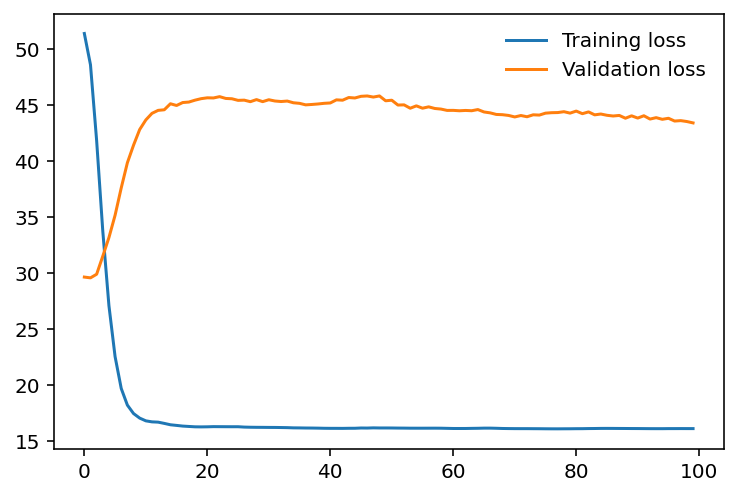

In [35]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)